In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read in the data to a pandas DataFrame using the read_csv method.

train=pd.read_excel('Normalized_relative_quantities.xlsx')

#train

In [ ]:
#Let's plot two random columns to see the distribution
plt.clf()
sns.distplot(train['hsa-miR-1274A-002883'])
plt.title('hsa-miR-1274A-002883')
plt.show()

plt.clf()
sns.distplot(train['hsa-miR-342-3p-002260'])
plt.title('hsa-miR-342-3p-002260')
plt.show()

#Here we confirm that the miRNAs follow the "normal" negative binomial distribution for gene expression data 

In [ ]:
#Let's see again how many missing data there are / column
train.isna().sum()

In [2]:
#As we see we have 7 individuals with no prediction over if they are going to develop dm or cm ("inc_dm_2009", "inc_cv_2009"), 
#so we need to remove them from the downstream analysis 

train = train.dropna(how='any', subset=['inc_dm_2009', 'inc_cv_2009'])

#we are also going to remove sample ids labels
train = train.drop('CardID', 1)

train.shape

(553, 49)

In [15]:
#Unbalanced dataset - as it is

#Our feature varuables (all numerical) start from the 3rd column
X = train.iloc[:,3:]

#Our target variable is the "inc_dm_2009" or "inc_cv_2009" column
y = train['inc_dm_2009']
#we can convert it to integer 
y = y.astype(int)

#See if there is imbalance of the target value
train['inc_dm_2009'].value_counts()

#Yes there is - 1 cases 2.5 times more - so we will try a stratified split

0.0    398
1.0    155
Name: inc_dm_2009, dtype: int64

In [ ]:
# Balanced dataset - Up-sample Minority Class

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train[train['inc_dm_2009']==0].drop(['inc_cv_2009'], axis=1)
df_minority = train[train['inc_dm_2009']==1].drop(['inc_cv_2009'], axis=1)

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=398,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


X = df_upsampled.iloc[:,3:]
y = train['inc_dm_2009']

# Display new class counts
df_upsampled['inc_dm_2009'].value_counts()

In [13]:
# Balanced dataset - Down-sample Majority Class

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train[train['inc_dm_2009']==0].drop(['inc_cv_2009'], axis=1)
df_minority = train[train['inc_dm_2009']==1].drop(['inc_cv_2009'], axis=1)

# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=155,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
#df_upsampled['inc_dm_2009'].value_counts()

X = df_downsampled.iloc[:,3:]
y = train['inc_dm_2009']

# Display new class counts
df_downsampled['inc_dm_2009'].value_counts()

In [16]:
# Unbalanced - splitting after process
### - Let's test a little cheating
#First we will process all the dataset and then we will split our training and testing sets

X_log = np.log2(X)

#Imputation

#remove columns with missing data > 10% in the whole dataset and impute:
cols = X_log.columns[X_log.isnull().mean() < 0.1]
print(cols)
#set sets with those columns
X_log_flt = X_log[cols]

#13/49 features were removed

# will fit and transform with KNN imputation
from sklearn.impute import KNNImputer
    
imputer = KNNImputer(n_neighbors=2, weights="uniform")

X_imp = imputer.fit_transform(X_log_flt)

X_imp = X_log_flt

#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_sc = scaler.fit_transform(X_imp)

#Split the set

from sklearn.model_selection import train_test_split

X_train_sc, X_test_sc, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=0, stratify = y)


Index(['hsa-miR-17-002308', 'hsa-miR-1274B-002884', 'hsa-miR-625*-002432',
       'hsa-miR-223-002295', 'hsa-miR-126-002228', 'hsa-miR-484-001821',
       'hsa-miR-320-002277', 'hsa-miR-191-002299', 'hsa-miR-106a-002169',
       'hsa-let-7b-002619', 'mmu-miR-451-001141', 'hsa-miR-342-3p-002260',
       'hsa-miR-338-5P-002658', 'hsa-let-7e-002406', 'hsa-miR-486-001278',
       'hsa-miR-222-002276', 'hsa-miR-483-5p-002338', 'hsa-miR-146b-001097',
       'hsa-miR-20b-001014', 'hsa-miR-574-3p-002349', 'hsa-miR-186-002285',
       'hsa-miR-146a-000468', 'hsa-miR-92a-000431', 'hsa-miR-24-000402',
       'hsa-miR-150-000473', 'hsa-miR-19b-000396', 'hsa-miR-197-000497',
       'hsa-miR-16-000391', 'hsa-miR-20a-000580', 'hsa-miR-30c-000419',
       'hsa-miR-21-000397', 'hsa-miR-30b-000602', 'hsa-miR-26a-000405',
       'hsa-miR-142-3p-000464', 'hsa-miR-139-5p-002289', 'hsa-miR-720-002895'],
      dtype='object')


In [19]:
# Unbalanced - splitting before process

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

#A large amount of the total data is missing in some cases, with columns missing even 80% of the data ("hsa-miR-25-000403").

#The chosen imputation methods did not work well with data that follow the negative bionomial distribution so as to impute and
#log-transform and scale later --- so I will log normalise first, impute and then scale

#Let's log-transform miRNA values to follow the normal distribution
X_log = np.log2(X)

X_train_log = np.log2(X_train)

X_test_log = np.log2(X_test)

#Imputation - It was found that for microarray missing values the weighted nearest neighbors imputation (knn imputation) 
#is a popular method - we will use it in columns missing 10% of the feature values - rest of the columns will be removed

#remove columns with missing data > 10% in the whole dataset and then impute test and train sets:
cols = X_log.columns[X_log.isnull().mean() < 0.1]

#set sets with those columns
X_train_log_flt = X_train_log[cols]
X_test_log_flt = X_test_log[cols]

#13/49 features were removed

#imputation - I will fit and transform the train set and then fit to the test set in order to simulate real testing conditions
from sklearn.impute import KNNImputer
    
imputer = KNNImputer(n_neighbors=5, weights="uniform")

X_train_imp = imputer.fit_transform(X_train_log_flt)
X_test_imp = imputer.transform(X_test_log_flt) #Here we only need to transform the test data

#Now we will scale the data to [0,1] as it is necessary for some distance-based machine learning estimators (SVM, knn) 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc = scaler.transform(X_test_imp) #Here we only need to transform the test data

print('ready')

In [ ]:
#Our dataset is imbalanced with more negative than positive target values (2.5 times more) since diabetic patients are fewer
#than healthy patients in all study cohorts. That means that we would expect more false negatives 
#(diabetic identified as healthy) than false positives (healthy identified as diabetic), so F1-score 
#(the balance between Precision and Recall) is the most appropriate metric and the most interpretable one.
#On the other hand, a ROC curve is more insensitive to imbalancing data as it averages many F1-score values across a spectrum
#of different thresholds.

In [20]:
#SVM model

#svm is independent of the dimensionality of the feature space as the appriate selection of the regularisation parameter C 
#can prevent overfitting - so feature selection is not going to be applied here

#We will do a grid search with 3 types of kernels (linear, rbf, polynomial)
from time import process_time
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

t0= process_time()

parameters = [{'kernel':['linear'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000]}, 
              {'kernel':['rbf'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000]}]

svc = svm.SVC(class_weight='balanced')
svm_model = GridSearchCV(svc, parameters, cv = 5) #(Stratified)KFold is used as cross-validation strategy by default as 
                                                  #our target feature is binary

svm_model = svm_model.fit(X_train_sc, y_train) 
   
  

print("The best parameters are %s with a score of %0.2f"
      % (svm_model.best_params_, svm_model.best_score_))

t1 = process_time() - t0
print("Time elapsed: ", t1) #takes 40min to run



y_true, y_pred = y_test, svm_model.predict(X_test_sc)
print("Classification Report:", "\n", classification_report(y_true, y_pred))

print("Confusion Matrix:", "\n", confusion_matrix(y_true, y_pred))

The best parameters are {'C': 1, 'gamma': 100, 'kernel': 'rbf'} with a score of 0.72
Time elapsed:  13.40625
Classification Report: 
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        80
           1       0.00      0.00      0.00        31

    accuracy                           0.72       111
   macro avg       0.36      0.50      0.42       111
weighted avg       0.52      0.72      0.60       111

Confusion Matrix: 
 [[80  0]
 [31  0]]


/home/alexandros/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#Here we see that our model cannot predict any positive result. Maybe there is noise in the features?


#Let's reduce the feature dimensions using PCA and grid search again - I will do it for linear and rbf kernel seperately

from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

pca = decomposition.PCA()

svc = svm.SVC()

# Create a pipeline of two steps: 
# 1) tranform the data with PCA, 2) train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

# Create Parameter Space

# Create a list of a sequence of integers to integrate from PCA
n_components = list(range(1,X_train_sc.shape[1]+1,1))

# Create lists of parameter for SVC
#kernel = ['linear', 'rbf']
kernel = ['linear']
C = [0.001,0.01, 0.1, 1, 10, 100, 1000]

#kernel = ['rbf']
#gamma = [0.001,0.01, 0.1, 1, 10, 100, 1000]

parameters = dict(pca__n_components=n_components,
                      svc__kernel=kernel,
                      svc__C=C)

#parameters = dict(pca__n_components=n_components,
#                      svc__kernel=kernel,
#                      svc__C=C, svc__gamma=gamma)

svm_model = GridSearchCV(pipe, parameters, cv = 10)

svm_model.fit(X_train_sc, y_train)

print('Best Kernel:', svm_model.best_estimator_.get_params()['svc__kernel'])
print('Best C:', svm_model.best_estimator_.get_params()['svc__C'])
print('Best gamma:', svm_model.best_estimator_.get_params()['svc__gamma'])
print('Best Number Of Components:', svm_model.best_estimator_.get_params()['pca__n_components'])
print("Best Score: %0.2f" % svm_model.best_score_)
print()

y_true, y_pred = y_test, svm_model.predict(X_test_sc)
print("Classification Report:", "\n", classification_report(y_true, y_pred))

print("Confusion Matrix:", "\n", confusion_matrix(y_true, y_pred))

Best Kernel: linear
Best C: 0.001
Best gamma: scale
Best Number Of Components: 1
Best Score: 0.72

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        80
           1       0.00      0.00      0.00        31

    accuracy                           0.72       111
   macro avg       0.36      0.50      0.42       111
weighted avg       0.52      0.72      0.60       111

Confusion Matrix: 
 [[80  0]
 [31  0]]


/home/alexandros/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal number of features : 1


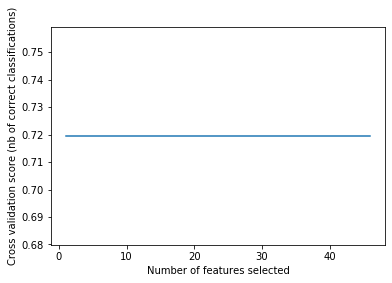

In [54]:
#Instead of reducing the feature dimensions using PCA, we will use try the recursive feature elimination in order to check
#if we could improve our model and discover which featuresare hughly ranked with the best hyperparameters
#It only works with the linear kernel so we will try it with the best values for linear found before 

from sklearn.feature_selection import RFECV
estimator = svm.SVC(kernel='linear', C=1) 
svc_rfe = RFECV(estimator, step=1, cv=5)
svc_rfe.fit(X_train_sc, y_train)

print("Optimal number of features : %d" % svc_rfe.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(svc_rfe.grid_scores_) + 1), svc_rfe.grid_scores_)
plt.show()

In [ ]:
#We see that recursive feature elimination does not improve our score. 

In [32]:
#Decision Trees

#Decision trees tend to overfit on data with a large number of features so first we will perform dimensionality reduction
#using pca

#The rationale is to take advantage of the Pipeline function of sklearn in order to grid search for the best number of PCA 
#components to input in our decision trees, and the best hyperparameters of our tree at the same time 

from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier()

# Create a pipeline of two steps: 
# 1) tranform the data with PCA, 2) train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('decisiontree', decisiontree)])

# Create Parameter Space

# Create a list of a sequence of integers to integrate from PCA
n_components = list(range(1,X_train_sc.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)


clf = GridSearchCV(pipe, parameters, cv = 15)

clf.fit(X_train_sc, y_train)

print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print("Best Score: %0.2f" % clf.best_score_)
print()

y_true, y_pred = y_test, clf.predict(X_test_sc)
print("Classification Report:", "\n", classification_report(y_true, y_pred))

print("Confusion Matrix:", "\n", confusion_matrix(y_true, y_pred))
    

Best Criterion: gini
Best max_depth: 4
Best Number Of Components: 1
Best Score: 0.71

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.97      0.83        80
           1       0.00      0.00      0.00        31

    accuracy                           0.70       111
   macro avg       0.36      0.49      0.41       111
weighted avg       0.52      0.70      0.59       111

Confusion Matrix: 
 [[78  2]
 [31  0]]


In [22]:
#Knn 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#define the model and parameters
knn = KNeighborsClassifier()


parameters = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21], #usually odd numbers
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance']}

#Fit the model
model_knn = GridSearchCV(knn, param_grid=parameters, cv = 5)
model_knn.fit(X_train_sc,y_train)

print('Best leaf_size:', model_knn.best_estimator_.get_params()['leaf_size'])
print('Best weight function:', model_knn.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', model_knn.best_estimator_.get_params()['n_neighbors'])
print('Best Score:', model_knn.best_score_)

y_true, y_pred = y_test, clf.predict(X_test_sc)
print("Classification Report:", "\n", classification_report(y_true, y_pred))

print("Confusion Matrix:", "\n", confusion_matrix(y_true, y_pred))

Best leaf_size: 1
Best weight function: distance
Best n_neighbors: 17
Best Score: 0.7103166496424923
Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.86      0.78        80
           1       0.15      0.06      0.09        31

    accuracy                           0.64       111
   macro avg       0.43      0.46      0.43       111
weighted avg       0.55      0.64      0.58       111

Confusion Matrix: 
 [[69 11]
 [29  2]]


In [ ]:
#predictions on the test data
prediction_knn = model_knn.score(X_test_sc, y_test)
print("Accuracy on test data:", prediction_knn)

In [ ]:
#maybe repeat knn with pca

In [ ]:
#Random Forests
#Let's tune the hyperparameters

#Here we will try a different approach - we will use randomize grid at first to limit our search space and then we will use
# a more exhaustive approach

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [200, 500, 1000, 1500, 2500]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(
    estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, n_jobs = -1)

rf_random.fit(X_train_sc, y_train)

print("Best Score:", rf_random.best_params_)
print("Best Score: %0.2f" % rf_random.best_score_)

In [ ]:
#Random Forests 2
#Let's see if we can improve the score by grinding search around the best parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#define the model and parameters
rf_v2 = RandomForestClassifier()

n_estimators = [300, 500, 800, 1000]
max_features = ['auto']
max_depth = [30, 40, 50, 60]
min_samples_split = [10, 15, 20, 25]
min_samples_leaf = [6, 8, 10, 12]
bootstrap = [True]

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Fit the model
model_rf_v2 = GridSearchCV(rf_v2, param_grid=parameters, cv = 5)
model_rf_v2.fit(X_train_sc,y_train)

print("Best Score:", model_rf_v2.best_params_)
print("Best Score: %0.2f" % model_rf_v2.best_score_)

In [ ]:
#The score did not change whatsoever

In [ ]:
#Logistic regression



In [ ]:
#feature importance
#https://machinelearningmastery.com/calculate-feature-importance-with-python/#:~:text=Feature%20importance%20refers%20to%20a,feature%20when%20making%20a%20prediction.

In [ ]:
#We will try:
#SVM
#General discriminant analysis
#Decision Trees
#Random Forest
#GLMs (generalized linear models) -- logistic regression tried in paper
#Ensembl of methods
#linear model elastic net

#do feature selection 


In [ ]:
#feature selection before SVM (PCA?)